## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [11]:
from keras.layers import BatchNormalization


def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


In [12]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [13]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.25, 0.5]
redice_lr_patient = [3, 5]

In [14]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-accuracy': model.history.history["accuracy"],
                             'valid-accuracy': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.25, reduce_patient: 3
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
______________________________________________________________

Epoch 12/25
49/49 [==============================] - 1s 26ms/step - loss: 1.5325 - accuracy: 0.4624 - val_loss: 1.6327 - val_accuracy: 0.4282
Epoch 13/25
49/49 [==============================] - 1s 27ms/step - loss: 1.5152 - accuracy: 0.4705 - val_loss: 1.6306 - val_accuracy: 0.4335
Epoch 14/25
49/49 [==============================] - 1s 27ms/step - loss: 1.4987 - accuracy: 0.4751 - val_loss: 1.6169 - val_accuracy: 0.4370
Epoch 15/25
49/49 [==============================] - 1s 26ms/step - loss: 1.4821 - accuracy: 0.4824 - val_loss: 1.6118 - val_accuracy: 0.4381
Epoch 16/25
49/49 [==============================] - 1s 26ms/step - loss: 1.4674 - accuracy: 0.4882 - val_loss: 1.6005 - val_accuracy: 0.4397
Epoch 17/25
49/49 [==============================] - 1s 27ms/step - loss: 1.4551 - accuracy: 0.4902 - val_loss: 1.5928 - val_accuracy: 0.4466
Epoch 18/25
49/49 [==============================] - 1s 27ms/step - loss: 1.4422 - accuracy: 0.4961 - val_loss: 1.5889 - val_accuracy: 0.4467
Epoch 

Epoch 1/25
49/49 [==============================] - 2s 34ms/step - loss: 2.5741 - accuracy: 0.1896 - val_loss: 2.2086 - val_accuracy: 0.1748
Epoch 2/25
49/49 [==============================] - 1s 27ms/step - loss: 2.0558 - accuracy: 0.3003 - val_loss: 2.1063 - val_accuracy: 0.2432
Epoch 3/25
49/49 [==============================] - 1s 27ms/step - loss: 1.8987 - accuracy: 0.3436 - val_loss: 2.0031 - val_accuracy: 0.2820
Epoch 4/25
49/49 [==============================] - 1s 28ms/step - loss: 1.8145 - accuracy: 0.3669 - val_loss: 1.9062 - val_accuracy: 0.3153
Epoch 5/25
49/49 [==============================] - 1s 27ms/step - loss: 1.7556 - accuracy: 0.3886 - val_loss: 1.8344 - val_accuracy: 0.3460
Epoch 6/25
49/49 [==============================] - 1s 27ms/step - loss: 1.7083 - accuracy: 0.4044 - val_loss: 1.7763 - val_accuracy: 0.3702
Epoch 7/25
49/49 [==============================] - 1s 28ms/step - loss: 1.6713 - accuracy: 0.4147 - val_loss: 1.7386 - val_accuracy: 0.3812
Epoch 8/25
49

47/49 [===========================>..] - ETA: 0s - loss: 0.5639 - accuracy: 0.8275
Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
49/49 [==============================] - 1s 28ms/step - loss: 0.5644 - accuracy: 0.8273 - val_loss: 1.4048 - val_accuracy: 0.5365
Epoch 22/25
49/49 [==============================] - 1s 28ms/step - loss: 0.5500 - accuracy: 0.8335 - val_loss: 1.3869 - val_accuracy: 0.5424
Epoch 23/25
49/49 [==============================] - 1s 28ms/step - loss: 0.5471 - accuracy: 0.8353 - val_loss: 1.3916 - val_accuracy: 0.5434
Epoch 24/25
48/49 [============================>.] - ETA: 0s - loss: 0.5447 - accuracy: 0.8364
Epoch 00024: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
49/49 [==============================] - 1s 27ms/step - loss: 0.5446 - accuracy: 0.8366 - val_loss: 1.3936 - val_accuracy: 0.5454
Epoch 25/25
49/49 [==============================] - 1s 27ms/step - loss: 0.5407 - accuracy: 0.8386 - val_loss: 1.394

Epoch 6/25
49/49 [==============================] - 1s 26ms/step - loss: 1.8468 - accuracy: 0.3577 - val_loss: 1.8556 - val_accuracy: 0.3412
Epoch 7/25
49/49 [==============================] - 1s 27ms/step - loss: 1.8173 - accuracy: 0.3679 - val_loss: 1.8257 - val_accuracy: 0.3491
Epoch 8/25
49/49 [==============================] - 1s 27ms/step - loss: 1.7931 - accuracy: 0.3739 - val_loss: 1.8080 - val_accuracy: 0.3579
Epoch 9/25
49/49 [==============================] - 1s 26ms/step - loss: 1.7709 - accuracy: 0.3805 - val_loss: 1.7947 - val_accuracy: 0.3651
Epoch 10/25
49/49 [==============================] - 1s 26ms/step - loss: 1.7522 - accuracy: 0.3878 - val_loss: 1.7862 - val_accuracy: 0.3742
Epoch 11/25
49/49 [==============================] - 1s 26ms/step - loss: 1.7361 - accuracy: 0.3932 - val_loss: 1.7774 - val_accuracy: 0.3750
Epoch 12/25
49/49 [==============================] - 1s 26ms/step - loss: 1.7210 - accuracy: 0.3961 - val_loss: 1.7682 - val_accuracy: 0.3794
Epoch 13/2

Epoch 1/25
49/49 [==============================] - 2s 35ms/step - loss: 1.8364 - accuracy: 0.3691 - val_loss: 2.2394 - val_accuracy: 0.2102
Epoch 2/25
49/49 [==============================] - 1s 30ms/step - loss: 1.5332 - accuracy: 0.4590 - val_loss: 1.8790 - val_accuracy: 0.3147
Epoch 3/25
49/49 [==============================] - 1s 29ms/step - loss: 1.4203 - accuracy: 0.4975 - val_loss: 2.2456 - val_accuracy: 0.2603
Epoch 4/25
49/49 [==============================] - 1s 28ms/step - loss: 1.3467 - accuracy: 0.5245 - val_loss: 2.0782 - val_accuracy: 0.3171
Epoch 5/25
49/49 [==============================] - ETA: 0s - loss: 1.2708 - accuracy: 0.5522
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
49/49 [==============================] - 1s 29ms/step - loss: 1.2708 - accuracy: 0.5522 - val_loss: 2.1142 - val_accuracy: 0.3443
Epoch 6/25
49/49 [==============================] - 1s 29ms/step - loss: 1.1233 - accuracy: 0.6083 - val_loss: 1.4239 - val_accuracy

49/49 [==============================] - 1s 29ms/step - loss: 2.5080 - accuracy: 0.2035 - val_loss: 2.4758 - val_accuracy: 0.1999
Epoch 16/25
49/49 [==============================] - ETA: 0s - loss: 2.5061 - accuracy: 0.2034
Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.525878978725359e-08.
49/49 [==============================] - 1s 29ms/step - loss: 2.5061 - accuracy: 0.2034 - val_loss: 2.4823 - val_accuracy: 0.2002
Epoch 17/25
49/49 [==============================] - 1s 30ms/step - loss: 2.5049 - accuracy: 0.2046 - val_loss: 2.4876 - val_accuracy: 0.1994
Epoch 18/25
49/49 [==============================] - 1s 30ms/step - loss: 2.5040 - accuracy: 0.2043 - val_loss: 2.4910 - val_accuracy: 0.1999
Epoch 19/25
49/49 [==============================] - 1s 30ms/step - loss: 2.5036 - accuracy: 0.2043 - val_loss: 2.4930 - val_accuracy: 0.1999
Epoch 20/25
49/49 [==============================] - 1s 29ms/step - loss: 2.5033 - accuracy: 0.2033 - val_loss: 2.4940 - val_accuracy: 0.19

Numbers of exp: 11, reduce_factor: 0.50, reduce_patient: 5
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_33 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_34 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
____________________________________________________________

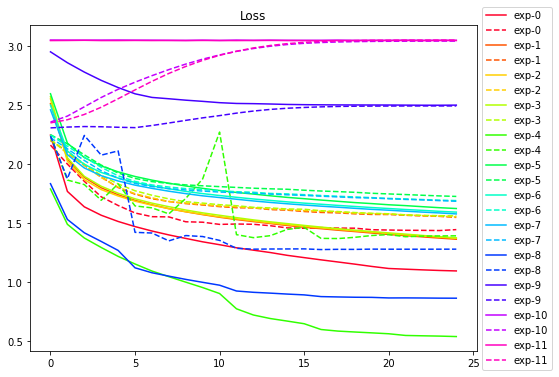

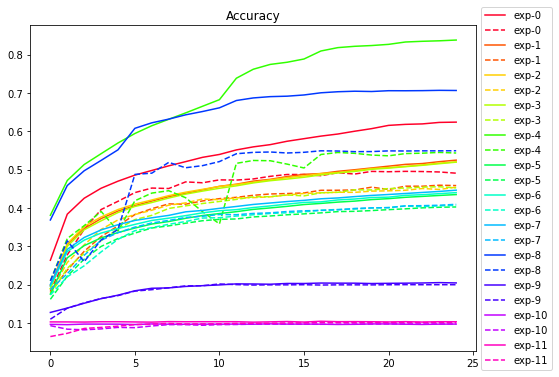

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-accuracy'])),results[cond]['train-accuracy'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-accuracy'])),results[cond]['valid-accuracy'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()